# <p><center style="font-family:newtimeroman;font-size:180%;"> Bone Fracture Classification and Quality Evaluation Using Image Analysis </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Data Augmentation](#4)
* [Train CNN Model](#5)
* [Evaluate The Model](#6)

In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [2]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [3]:
#train
train=data('/kaggle/input/bone-fracture/dataset/train')
train.head()

image          label
0  /kaggle/input/bone-fracture/dataset/train/not ...  not fractured
1  /kaggle/input/bone-fracture/dataset/train/not ...  not fractured
2  /kaggle/input/bone-fracture/dataset/train/not ...  not fractured
3  /kaggle/input/bone-fracture/dataset/train/not ...  not fractured
4  /kaggle/input/bone-fracture/dataset/train/not ...  not fractured

In [4]:
#test
test=data('/kaggle/input/bone-fracture/dataset/test')
test.head()

image          label
0  /kaggle/input/bone-fracture/dataset/test/not f...  not fractured
1  /kaggle/input/bone-fracture/dataset/test/not f...  not fractured
2  /kaggle/input/bone-fracture/dataset/test/not f...  not fractured
3  /kaggle/input/bone-fracture/dataset/test/not f...  not fractured
4  /kaggle/input/bone-fracture/dataset/test/not f...  not fractured

In [5]:
#val
val=data('/kaggle/input/bone-fracture/dataset/val')
val.head()

image          label
0  /kaggle/input/bone-fracture/dataset/val/not fr...  not fractured
1  /kaggle/input/bone-fracture/dataset/val/not fr...  not fractured
2  /kaggle/input/bone-fracture/dataset/val/not fr...  not fractured
3  /kaggle/input/bone-fracture/dataset/val/not fr...  not fractured
4  /kaggle/input/bone-fracture/dataset/val/not fr...  not fractured

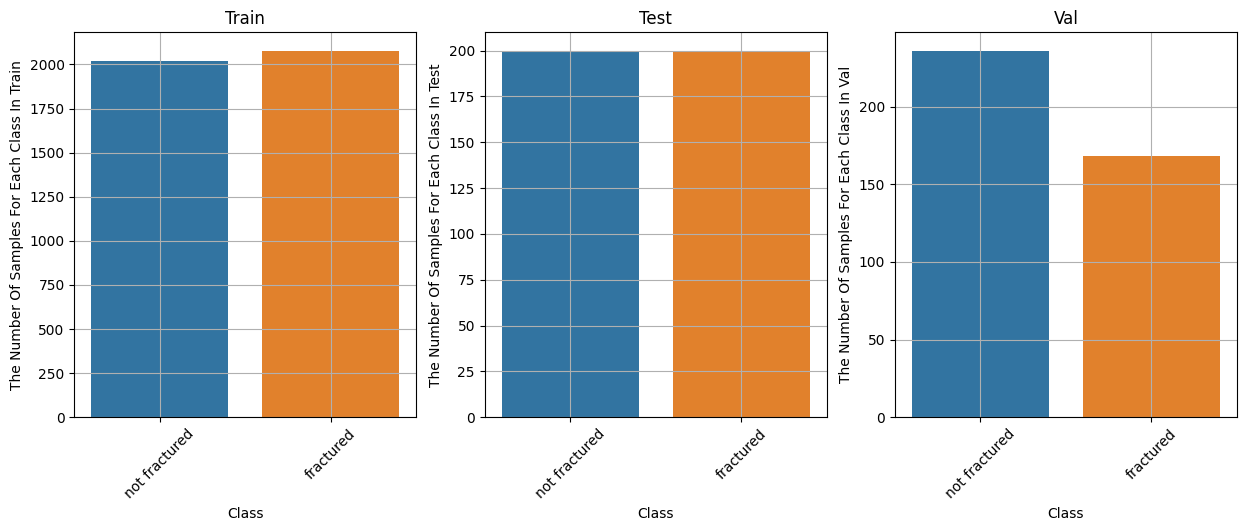

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
ax = sns.countplot(x=train.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,2)
ax = sns.countplot(x=test.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,3)
ax = sns.countplot(x=val.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Val")
plt.title('Val')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

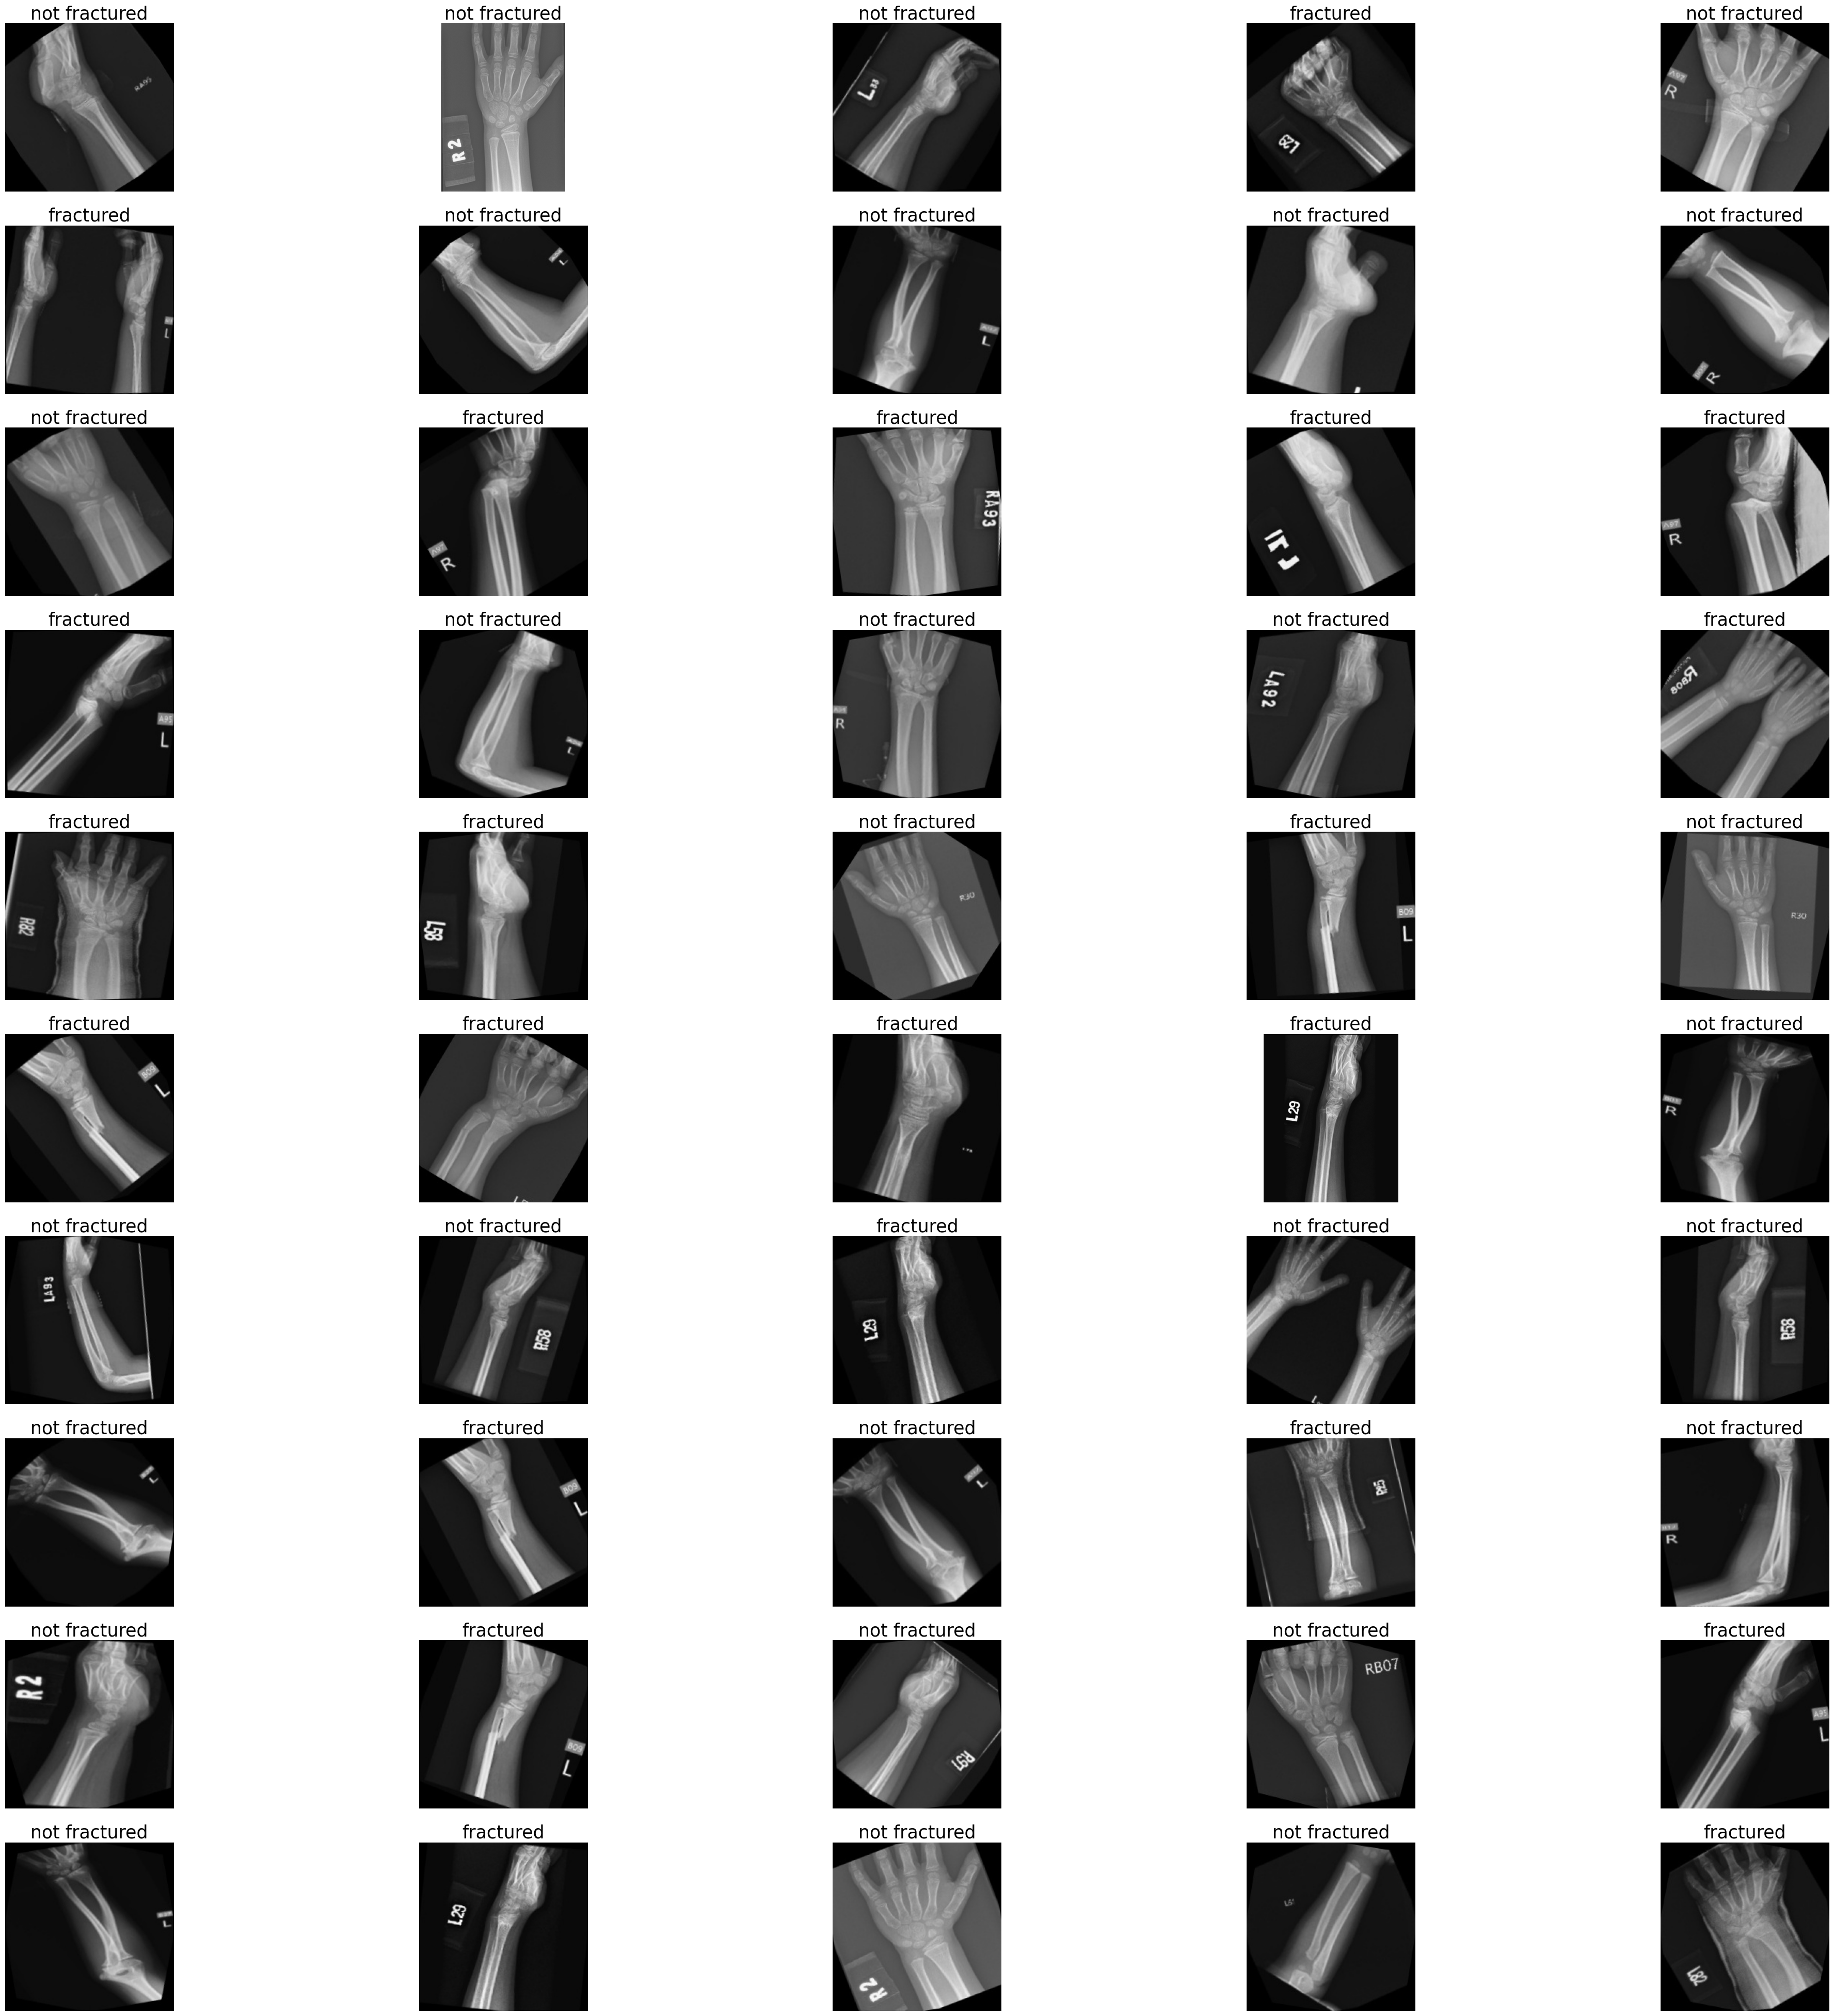

In [7]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

In [8]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


In [9]:
class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))  
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu)) 
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2))) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2))) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Dense(128,activation=tf.nn.relu)) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                        

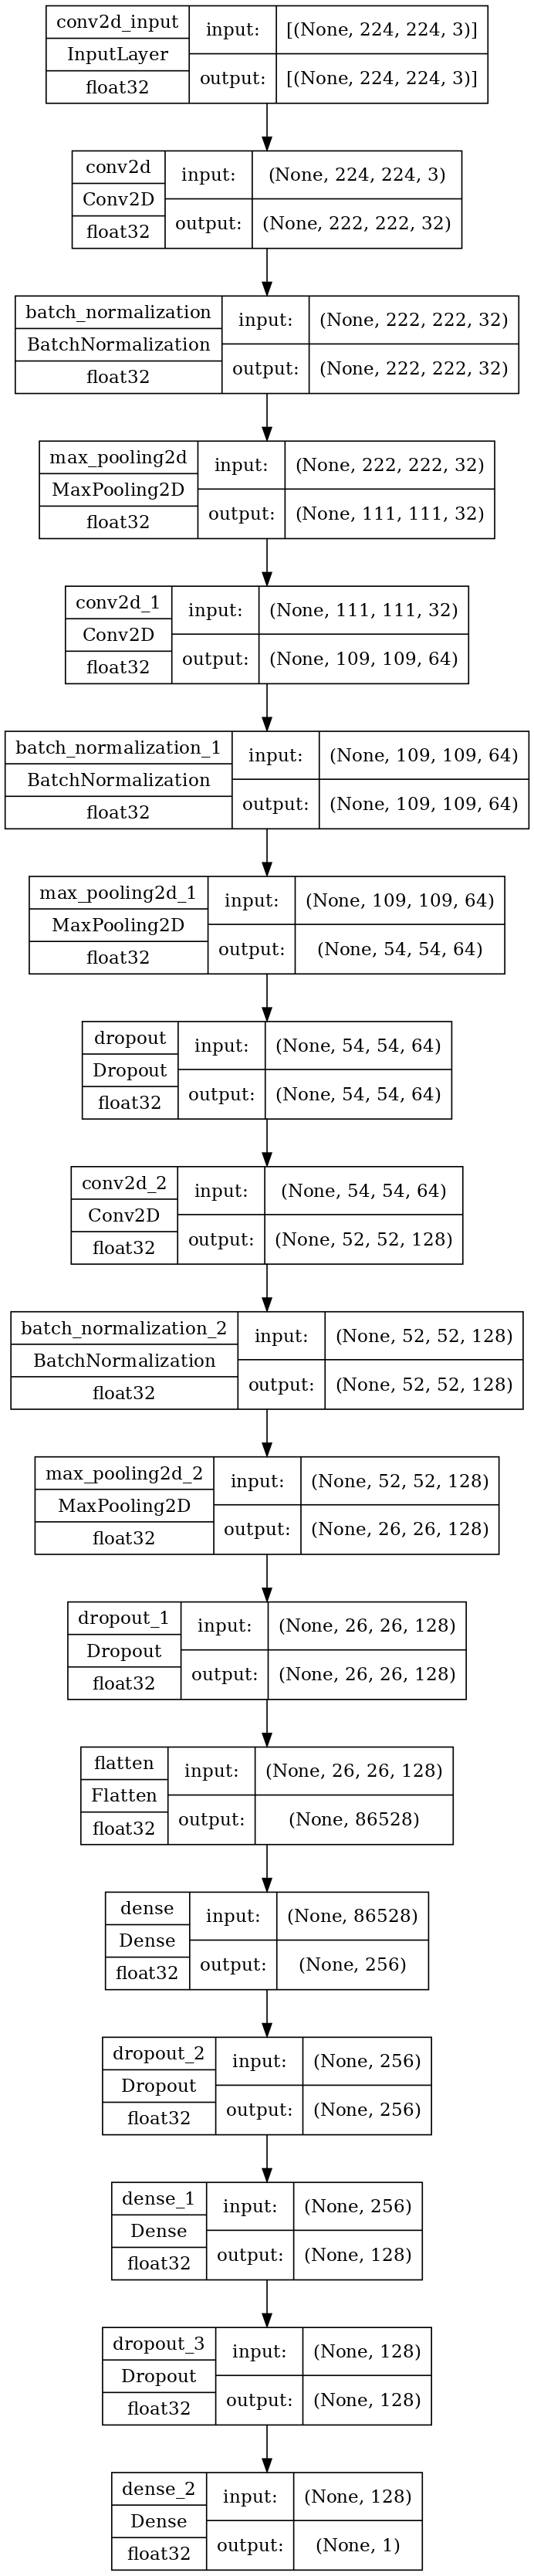

In [10]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [11]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
hist=model.fit_generator(train_generator,epochs=10,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])

/tmp/ipykernel_32/4118689137.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_generator,epochs=10,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])


Epoch 1/10
129/129 [==============================] - 432s 3s/step - loss: 2.6683 - accuracy: 0.7237 - specificity_at_sensitivity: 0.8479 - auc: 0.7700 - val_loss: 4.2973 - val_accuracy: 0.5842 - val_specificity_at_sensitivity: 0.1190 - val_auc: 0.4868
Epoch 2/10
129/129 [==============================] - 433s 3s/step - loss: 0.7742 - accuracy: 0.8509 - specificity_at_sensitivity: 0.9451 - auc: 0.9109 - val_loss: 1.6246 - val_accuracy: 0.6757 - val_specificity_at_sensitivity: 0.6369 - val_auc: 0.6608
Epoch 3/10
129/129 [==============================] - 424s 3s/step - loss: 0.5610 - accuracy: 0.8770 - specificity_at_sensitivity: 0.9697 - auc: 0.9372 - val_loss: 5.5192 - val_accuracy: 0.6238 - val_specificity_at_sensitivity: 0.3036 - val_auc: 0.5306
Epoch 4/10
129/129 [==============================] - 414s 3s/step - loss: 0.2661 - accuracy: 0.9273 - specificity_at_sensitivity: 0.9885 - auc: 0.9733 - val_loss: 2.2840 - val_accuracy: 0.6832 - val_specificity_at_sensitivity: 0.6012 - val_

In [12]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  specificity_at_sensitivity       auc  val_loss  \
0  2.668327  0.723700                    0.847931  0.769968  4.297276   
1  0.774199  0.850866                    0.945140  0.910881  1.624612   
2  0.560999  0.876983                    0.969682  0.937163  5.519187   
3  0.266086  0.927264                    0.988450  0.973312  2.283996   
4  0.163270  0.953381                    0.992300  0.985747  0.051425   
5  0.147267  0.958018                    0.993263  0.988724  0.086752   
6  0.118712  0.966805                    0.993744  0.990570  0.640227   
7  0.117706  0.972419                    0.993744  0.991405  0.079001   
8  0.072988  0.980718                    0.995669  0.994252  0.014150   
9  0.070434  0.980718                    0.995188  0.994669  0.004399   

   val_accuracy  val_specificity_at_sensitivity   val_auc  
0      0.584158                        0.119048  0.486822  
1      0.675743                        0.636905  0.660790  
2      0.623762                        0.303571  0.530556  
3      0.683168                        0.601190  0.692040  
4      0.982673                        0.994048  0.995889  
5      0.970297                        1.000000  0.995586  
6      0.866337                        0.892857  0.917474  
7      0.990099                        1.000000  0.993417  
8      0.995049                        1.000000  0.999874  
9      0.997525                        1.000000  1.000000

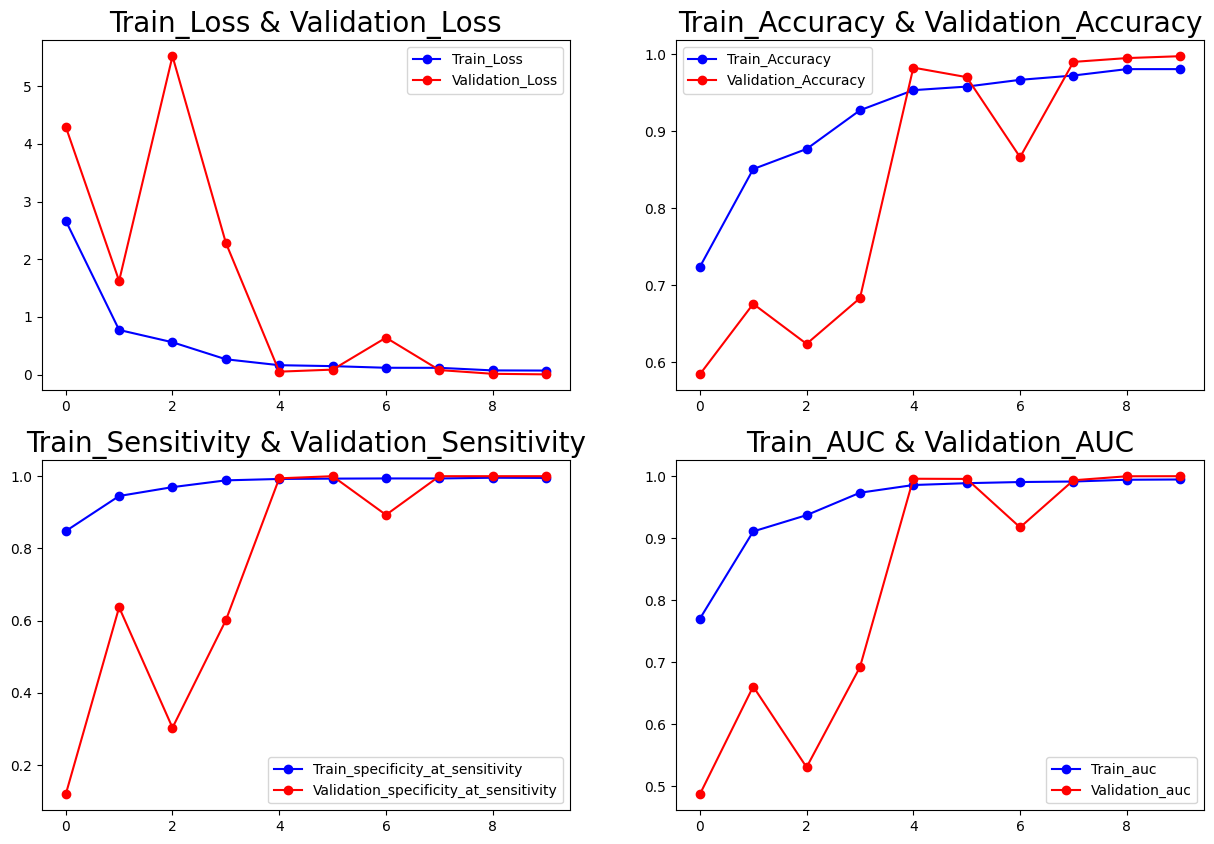

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [14]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

13/13 [==============================] - 10s 782ms/step - loss: 0.0715 - accuracy: 0.9875 - specificity_at_sensitivity: 1.0000 - auc: 0.9972
Test Loss = 0.07153299450874329
Test Accuracy = 0.9874686598777771
Test Sensitivity = 1.0
Test AUC = 0.9972487688064575


In [15]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 [==============================] - 10s 778ms/step


Actual  Prediction
0         1           1
1         1           1
2         1           1
3         1           1
4         1           1
..      ...         ...
394       0           0
395       0           0
396       0           0
397       0           0
398       0           0

[399 rows x 2 columns]

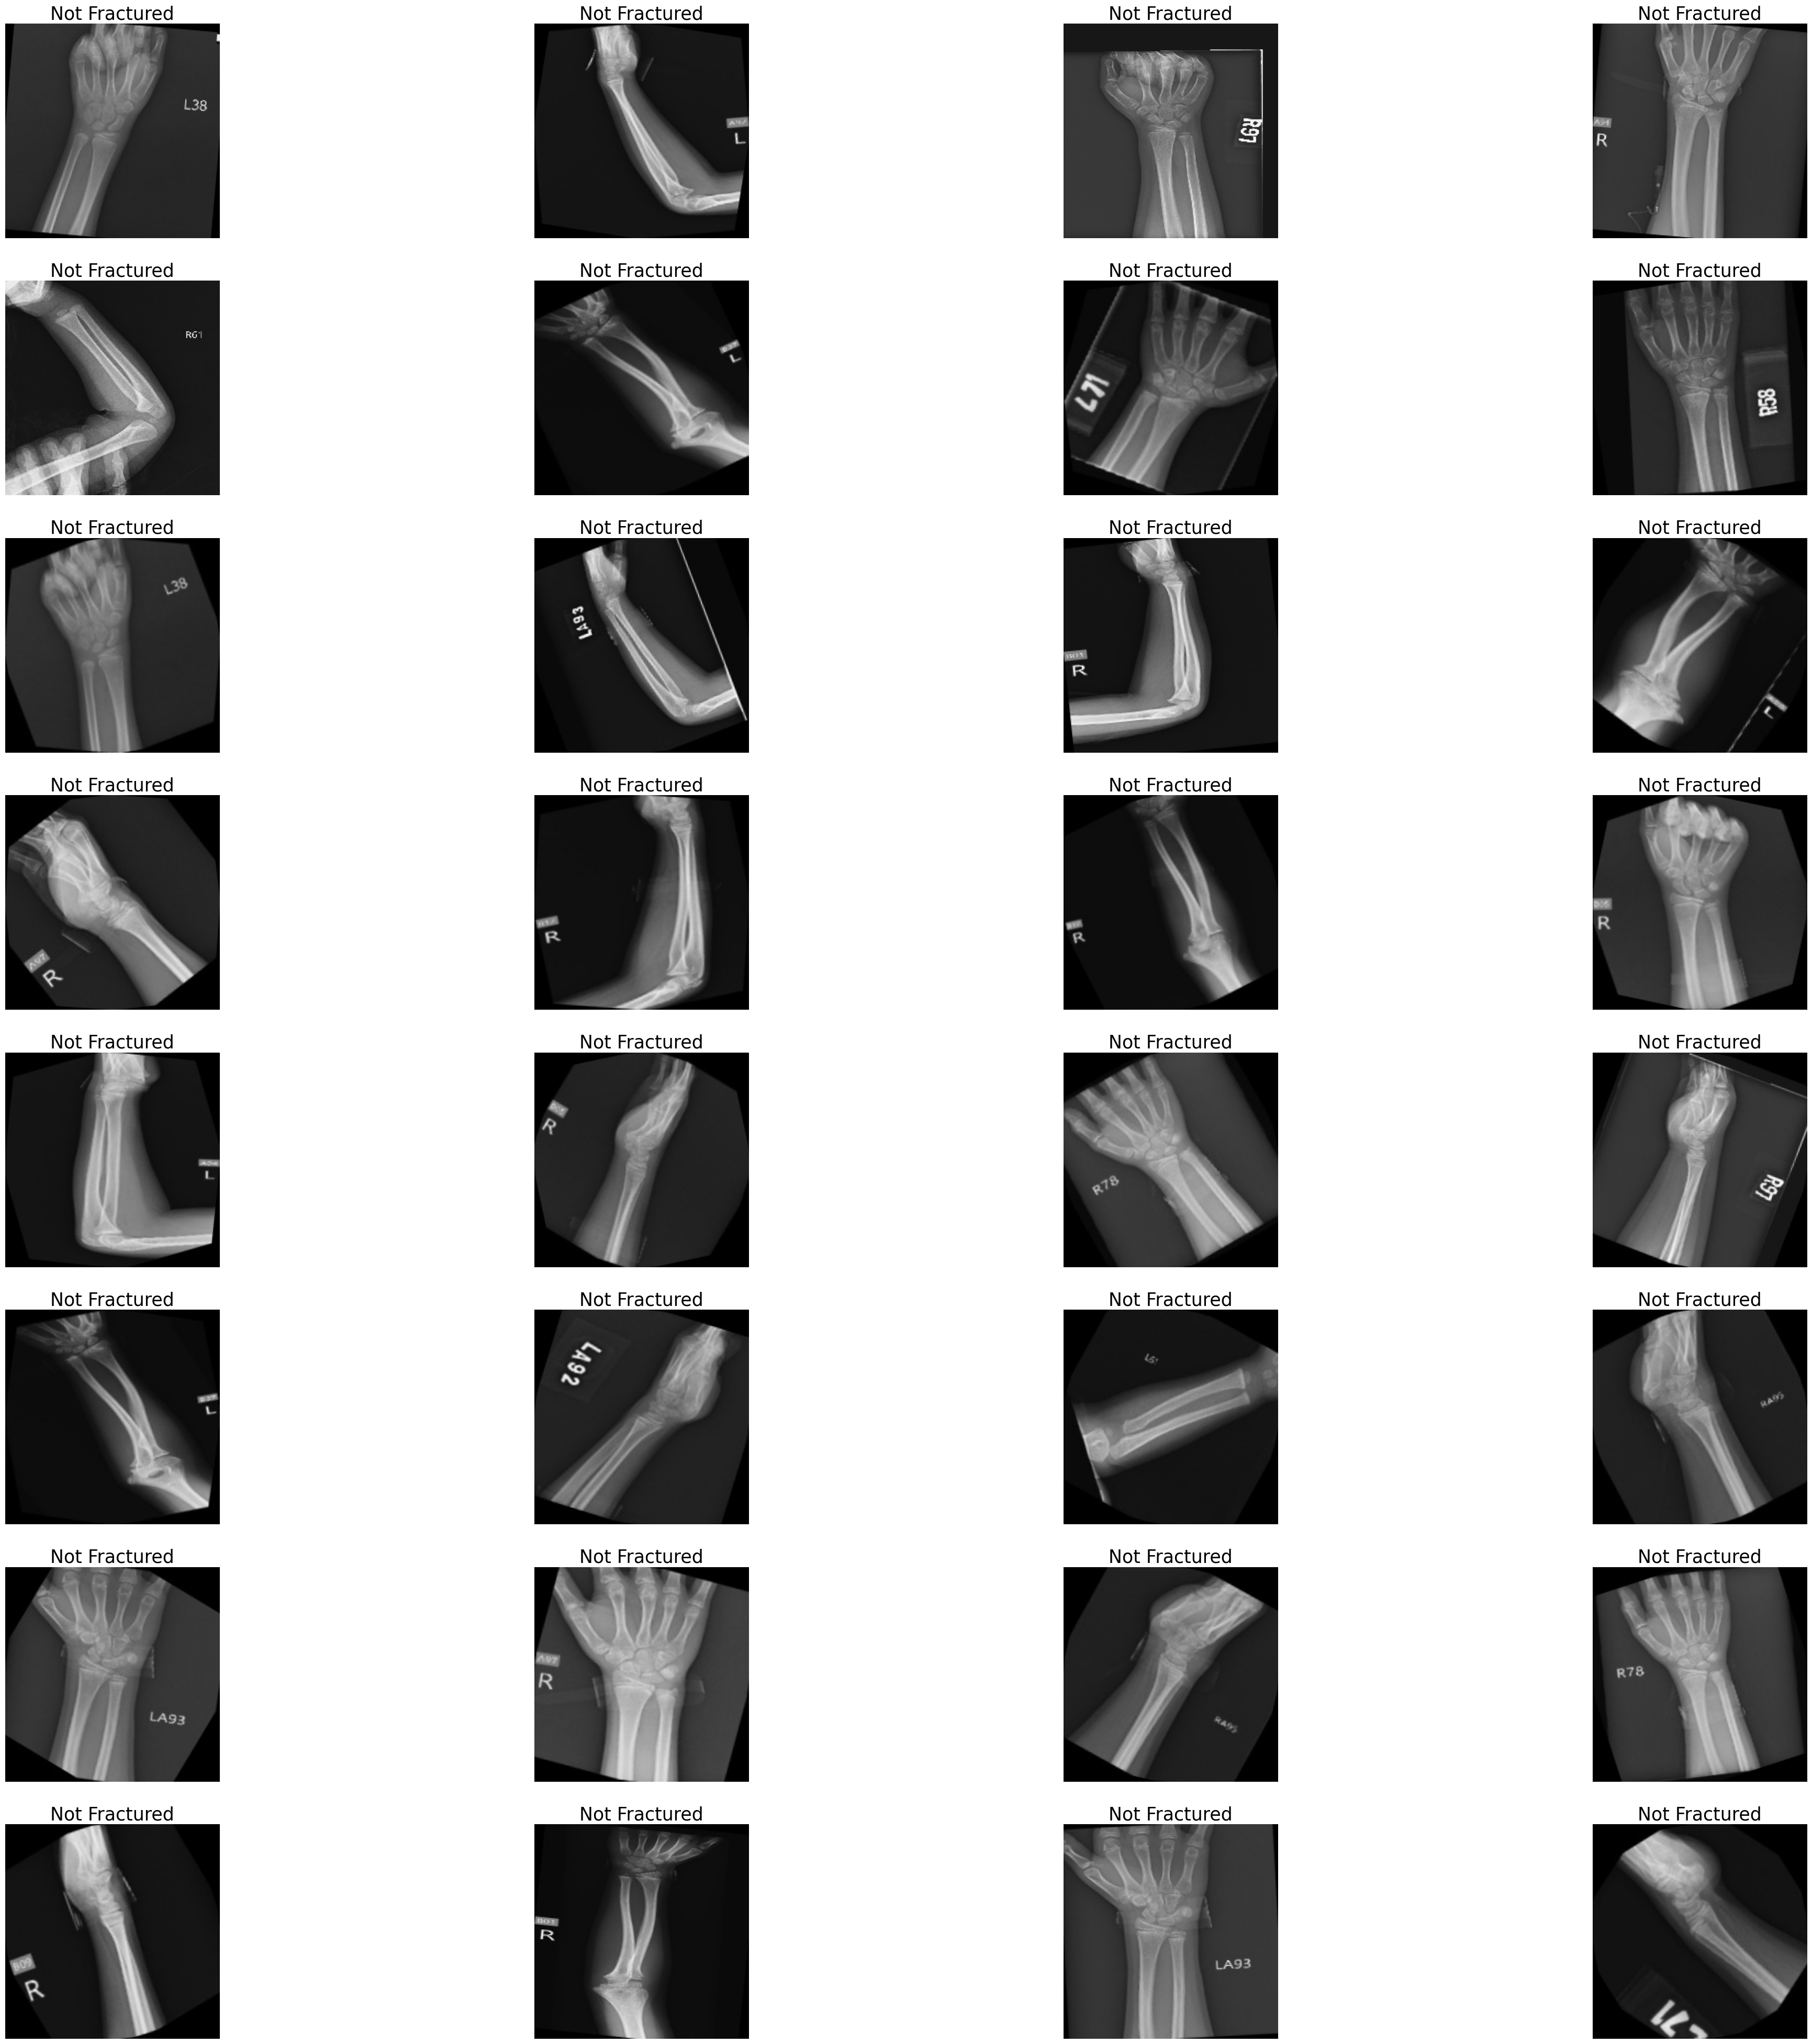

In [16]:
class_names=['Fractured', 'Not Fractured']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

array([[199,   0],
       [  5, 195]])

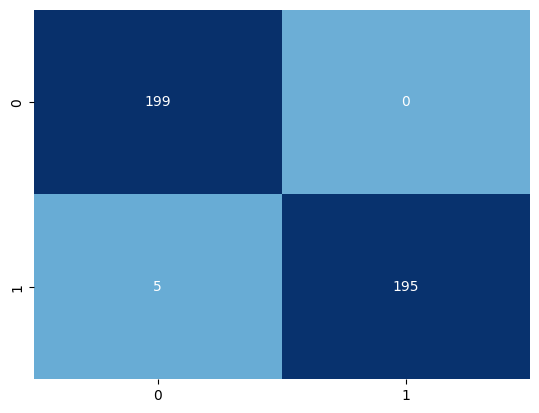

In [17]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [20]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ')
print(ClassificationReport )

Classification Report is : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       199
           1       1.00      0.97      0.99       200

    accuracy                           0.99       399
   macro avg       0.99      0.99      0.99       399
weighted avg       0.99      0.99      0.99       399



In [31]:
model.save('/kaggle/output/my_keras_model.h5')


In [23]:
import cv2
import numpy as np
from keras.preprocessing import image

def classify_bone_fracture(model, image_path):
    # Load and preprocess the input image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Assuming your model expects input shape (224, 224, 3)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize pixel values

    # Make prediction
    prediction = model.predict(img)

    # Print the prediction
    if prediction <= 0.5:
        print("The model predicts: Bone Fracture")
    else:
        print("The model predicts: No Bone Fracture")

# Get image path from user input
image_path_to_classify = input("Enter the path of the image to classify: ")
classify_bone_fracture(model, image_path_to_classify)


Enter the path of the image to classify:  /kaggle/input/bone-fracture/dataset/test/fractured/1-rotated1-rotated2-rotated1.jpg


1/1 [==============================] - 0s 74ms/step
The model predicts: Bone Fracture
